In [1]:
# Make sure accelerate is installed otherwise the following error may be raised
"""
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. 
Defaulting to `low_cpu_mem_usage=False`. 
It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. 
You can do so with: 
    ```
    pip install accelerate
    ```
"""

import os
import gc
import numpy as np
from dataclasses import dataclass
from tqdm.auto import tqdm
from math import ceil

# TODO see how to compile torch with flash attention
import torch
from torchvision import transforms as tfms

from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer, logging
from huggingface_hub import notebook_login

from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image

# TODO this will have to be changed for the main.py code
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress CLIPTextModel warnings
logging.set_verbosity_error()

c:\Users\diogo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# TODO make it so that when the pipeline is created the text embeddings and scheduler are generated then can be visualised straight away
class StableDiffusionPipeline():

    def __init__(self, prompt, inference_steps, guidance_scale,
                 height=512, width=512,
                 seeded_generator=torch.manual_seed(32)):
        self.prompt = prompt

        self.inference_steps = inference_steps
        self.guidance_scale = guidance_scale

        self.height = height
        self.width = width

        self.seeded_generator = seeded_generator

        # Device
        self.initialise_device()

        # Components
        self.initialise_components()
        self.components_to_gpu()

        # Initialise embeddings, scheduler and latents that are required prior to inference
        self.initialise_text_embeddings(self.prompt)
        self.initialise_scheduler()
        self.initialise_latents()

    def initialise_device(self):
        # Set device based on CUDA, MPS (MacOS), CPU
        self.device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

        if "mps" == self.device: 
            os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

    def initialise_components(self):
        # TODO update this so that the pretrained can be chosen or the custom trained vae / unet

        # Load the autoencoder model which will be used to decode the latents into image space.
        self.vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

        # Load the tokeniser and text encoder to tokenize and encode the text.
        # CLIP uses a ViT like transformer that gets visual features and a causal language model for the text features
        # Both the text and visual features are proejcted into a latent space with  identical dimensions and a dot product between the projected image and the text features is used as a similarity score
        # Images are split into fixed-size and non overlapping sequendes called patches - positional embeddings are also added.
        # If needed images can be resized and normalised using the CLIPImageProcessor
        # The CLIPTokeniser encodes the text
        self.tokeniser = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
        self.text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

        # The UNet model for generating the latents.
        self.unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

        # TODO test out a list of all the other schedulers - see if diffusers module has a variable to list them all out
        self.scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

    def components_to_gpu(self):
        # Move the initialised components to the gpu
        self.vae = self.vae.to(self.device)
        self.text_encoder = self.text_encoder.to(self.device)
        self.unet = self.unet.to(self.device)

    # TODO separate the text encoder and tokeniser into a separate class
    def initialise_text_embeddings(self, prompt):
        # Conditioned text embeddings
        self.prompt_tokens = self.tokeniser(prompt, padding="max_length", max_length=self.tokeniser.model_max_length, truncation=True, return_tensors="pt")
        with torch.no_grad():
            # text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]
            text_embeddings = self.get_embeddings(self.prompt_tokens.input_ids.to(self.device))
        
        # Matching the conditioned max max length and creating the unconditioned embeddings
        max_length = self.prompt_tokens.input_ids.shape[-1]
        uncond_input = self.tokeniser([""], padding="max_length", max_length=max_length, return_tensors="pt")
        with torch.no_grad():
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

        # Concatenate both
        self.text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    def visualise_tokenisation(self, show_tensor=True, show_attention_mask=True):
        # Starts off with a prompt - then we tokenise it into a series of tokens using our CLIPTokeniser
        # This tokeniser makes sure it is padded
        printed_tokens = set()

        if show_tensor or show_attention_mask:
            if show_tensor:
                print(f"Tokenised text tensor:\n{self.prompt_tokens['input_ids'][0]}\n")
            if show_attention_mask:
                print(f"Tokenised text tensor:\n{self.prompt_tokens['attention_mask'][0]}\n")
        else:
            print("For the sake of clarity the padded tokens and the attention mask are removed from the output, run this method with show_tensor=True and/or attention_mask=True to see them respectively.\n")

        # See the individual tokens
        for token in self.prompt_tokens['input_ids'][0]:
            token_value = int(token)
            if token_value not in printed_tokens:
                print(f"Token: {token} - Value: {self.tokeniser.decoder.get(token_value)}")
                printed_tokens.add(token_value)

    def build_causal_attention_mask(self, bsz, seq_len, dtype):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(bsz, seq_len, seq_len, dtype=dtype)
        mask.fill_(torch.tensor(torch.finfo(dtype).min))
        mask.triu_(1)  # zero out the lower diagonal
        mask = mask.unsqueeze(1)  # expand mask
        return mask

    def get_embeddings(self, input_embeddings):
        # TODO undestand code and comment it
        token_embeddings = self.text_encoder.text_model.embeddings.token_embedding(input_embeddings)
        # TODO why only 77
        position_ids = self.text_encoder.text_model.embeddings.position_ids[:, :77]
        positional_embeddings = self.text_encoder.text_model.embeddings.position_embedding(position_ids)

        embedding = token_embeddings + positional_embeddings

        # CLIP's text model uses causal mask, so we prepare it here:
        bsz, seq_len = embedding.shape[:2]
        causal_attention_mask = self.build_causal_attention_mask(bsz, seq_len, embedding.dtype)

        # Getting the output embeddings involves calling the model with passing output_hidden_states=True
        # so that it doesn't just return the pooled final predictions:
        encoder_outputs = self.text_encoder.text_model.encoder(
            inputs_embeds=embedding,
            attention_mask=None,
            causal_attention_mask=causal_attention_mask.to(self.device),
            output_attentions=None,
            output_hidden_states=True,
            return_dict=None,
        )

        # We're interested in the output hidden state only
        output = encoder_outputs[0]

        # There is a final layer norm we need to pass these through
        output = self.text_encoder.text_model.final_layer_norm(output)
        return output

    def initialise_scheduler(self):
        self.scheduler.set_timesteps(self.inference_steps)
        self.scheduler.timesteps = self.scheduler.timesteps.to(torch.float32)

    def visualise_scheduler(self, scheduler=None, timesteps=None):
        # TODO figure out how scheduler.scale_model_input works and what it does (what scaling / pre conditioning is)
        if not scheduler:
            scheduler = self.scheduler

        if timesteps:
            scheduler.set_timesteps(timesteps)

        # Visualising the sigmas (the amount of noise) that the scheduler will choose to add to our latents
        plt.plot(scheduler.sigmas)
        plt.title('Noise Schedule')
        plt.xlabel('Steps')
        plt.ylabel('Sigma')
        plt.show()

    def visualise_noised_latents(self, latents, scheduler, timesteps):
        max_timesteps = len(scheduler.timesteps)
        assert timesteps < max_timesteps, "The timestep chosen to visualise the noised image must be lower than the current max {max_timesteps}"

        noise = torch.rand_like(latents)
        # This add noise function is the same noised_sample = original + noise * sigmas
        encoded_and_noised = scheduler.add_noise(latents, noise, timesteps=torch.tensor([scheduler.timesteps[timesteps]]))
        decoded_latents = self.decode_latents(encoded_and_noised.float().to("cuda"))
        plt.imshow(self.scale_image(decoded_latents))

    def initialise_latents(self):
        # Prep latents - our latents are 64x smaller so we generate the noise in the latent dimension
        self.latents = torch.randn(
            (1, self.unet.config.in_channels, self.height // 8, self.width // 8),
            generator=self.seeded_generator,
        )
        self.latents = self.latents.to(self.device)
        self.latents = self.latents * self.scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

    def update_prompt(self, prompt):
        self.prompt = prompt
        self.initialise_text_embeddings(self.prompt)

    def image_to_latents(self, image):
        # Output the latents of a single image
        with torch.no_grad():
            # TODO break down this scaling into separate components and explain it
            latent = self.vae.encode(tfms.ToTensor()(image).unsqueeze(0).to(self.device)*2-1) # Note scaling
        images = 0.18215 * latent.latent_dist.sample()
        images = images.to("cpu")
        self.display_images(np.array(images[0]), 4, cmap="gray")
        return images

    def decode_latents(self, latents):
        # TODO figure out why these are scaled
        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents
        with torch.no_grad():
            return self.vae.decode(latents).sample

    def scale_image(self, image):
        # TODO understand and comment why this is done
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        image = (image * 255).round().astype("uint8")
        return Image.fromarray(image[0])

    def show_generated_image(self):
        plt.imshow(self.image)

    def display_images(self, images, cols=1, **kwargs):
        num_images = len(images)
        rows = ceil(num_images / cols)

        # Create subplots and flatten it so that we get an easy iterable
        _, axs = plt.subplots(rows, cols, figsize=(15, 5*rows))
        axs = axs.flatten()
        
        # Iterate through the images and plot them - making sure to turn off the axis
        for i, image in enumerate(images):
            axs[i].imshow(image, **kwargs)
            axs[i].axis('off')

        # We can use the remainder of the i variable to hide any unused subplots
        for j in range(i + 1, len(axs)):
            axs[j].axis('off')

        # Adjust layout to prevent overlapping
        plt.tight_layout()
        plt.show()

    def generate(self, show=True):
        # TODO set a setting to turn off autocast when there is a mixed precision error - e.g training locally and add this to read me
        # with autocast("cuda"):  # will fallback to CPU if no CUDA; no autocast for MPS
        for _, t in tqdm(enumerate(self.scheduler.timesteps), total=len(self.scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([self.latents] * 2)

            # TODO (Understand this) Scale the latents (preconditioning):
            # sigma = self.scheduler.sigmas[i]
            # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=self.text_embeddings).sample

            # Guidance
            # Use .chunk to split the noise prediction of the two concatenated tensors into the unconditioned noise prediction
            # and the conditioned on text noise prediction, these are then updated using the guidance scale formula
            # Take the difference between the conditioned and the unconditioned noise - the higher the guidance scale the more we follow the conditioned noise
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
            self.latents = self.scheduler.step(noise_pred, t, self.latents).prev_sample

        self.image = self.decode_latents(self.latents)
        self.image = self.scale_image(self.image)
        if show == True:
            self.show_generated_image()

        # self.clear_cuda()

        return self.image

    def clear_cuda(self):
        # Clearing CUDA so that it does not run out of memory during multiple instantiations - big problem especially in notebooks
        torch.cuda.synchronize()
        gc.collect()
        torch.cuda.empty_cache()
        

100%|██████████| 10/10 [04:53<00:00, 29.35s/it]


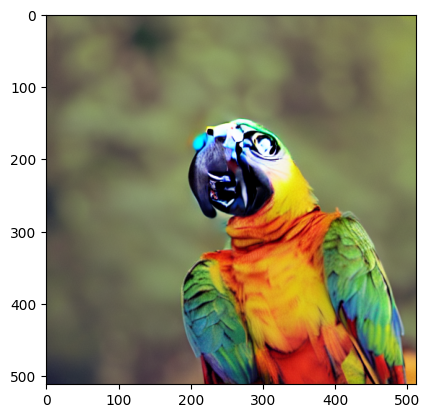

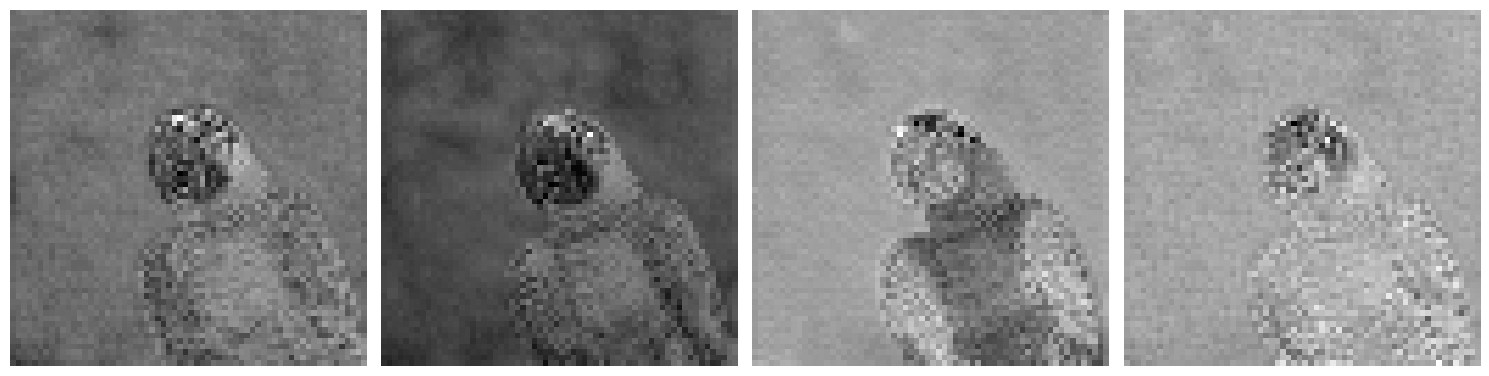

10
Tokenised text tensor:
tensor([49406,   320, 23565, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

Tokenised text tensor:
tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0])

Token: 49406 - Value: <|startoftext|>
Token: 320 - Value: a</w>
Token: 23565 - Va

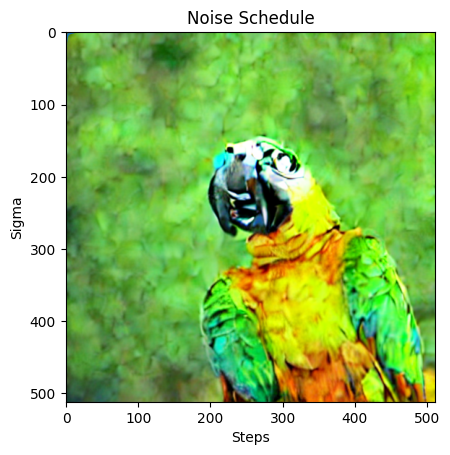

In [5]:
# TODO create a config like GPT
@dataclass
class SDPipelineConfig:
    """
    Stable Diffusion Pipeline Config
    prompt: The text prompt you want to condition the image generation on
    height: Height of image generated                            
    width: Width of image generated                              
    inference_steps: Number of diffusion steps that you want to take place                   
    guidance_scale: Guidance value that affects how closely the prompt affects diffusion                        
    seed: Random generation seed to keep results reproducible
    """
    prompt: str = "A parrot"
    height: int = 512                              
    width: int = 512                                 
    inference_steps: int = 15                         
    guidance_scale: float = 7.5                        
    seed: int = 42

    # TODO see if any assertions can be added here to make sure the values are good e.g height and width being a factor of 8 (explain why too)

prompt = "A parrot"
height = 512                               
width = 512                                 
inference_steps = 10                         
guidance_scale = 7.5 
seeded_generator = torch.manual_seed(65)

# Generating an image and the visualising its latents
pipeline = StableDiffusionPipeline(prompt, inference_steps, guidance_scale)
image = pipeline.generate(show=True)

latents = pipeline.image_to_latents(image)
pipeline.visualise_noised_latents(latents, pipeline.scheduler, 5)
pipeline.visualise_tokenisation(show_tensor=True, show_attention_mask=True)
pipeline.visualise_scheduler()


In [ ]:
# TODO add this function as a callback that can be triggered whenever - check if there are any other callbacks that can be used

def show_gpu_usage():
    if torch.cuda.is_available():
        megabyte = 1024 ** 2
        gpu_memory_allocated = torch.cuda.memory_allocated(0) / megabyte
        gpu_memory_reserved = torch.cuda.memory_reserved(0) / megabyte
        print(f"Memory Allocated: {gpu_memory_allocated:.2f} MB")
        print(f"Memory Reserved: {gpu_memory_reserved:.2f} MB")
    else:
        print("CUDA is not currently in use.")

In [ ]:
# TODO split into a visualiser class, that has all the visualisation functions

# TODO selection of the custom networks along with training them